In [1]:
import matplotlib.pyplot as plt
# follow the tutorial at http://docs.lightkurve.org/tutorials/03-making-custom-apertures.html
from lightkurve import search_targetpixelfile
# get the pixel data for all quarters
pixelfile = search_targetpixelfile('KIC 4175557').download_all();

In [2]:
pixelfile

TargetPixelFileCollection of 11 objects:
	4175557 (11 KeplerTargetPixelFiles) Quarters: 4,5,7,8,9,11,12,13,15,16,17

/Users/steve/opt/anaconda3/lib/python3.8/site-packages/lightkurve/utils.py:459: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)
/Users/steve/opt/anaconda3/lib/python3.8/site-packages/lightkurve/utils.py:459: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)
/Users/steve/opt/anaconda3/lib/python3.8/site-packages/lightkurve/utils.py:459: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)
/Users/

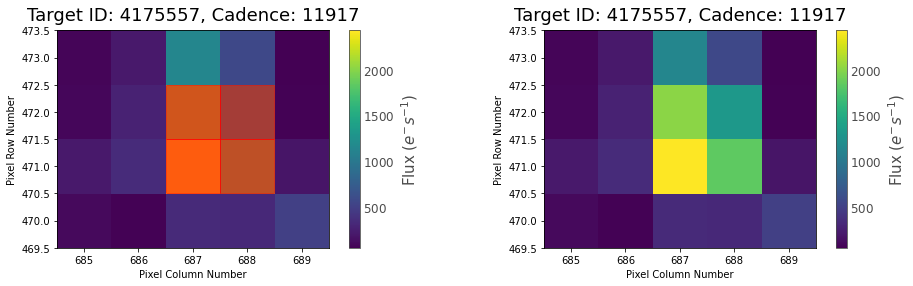

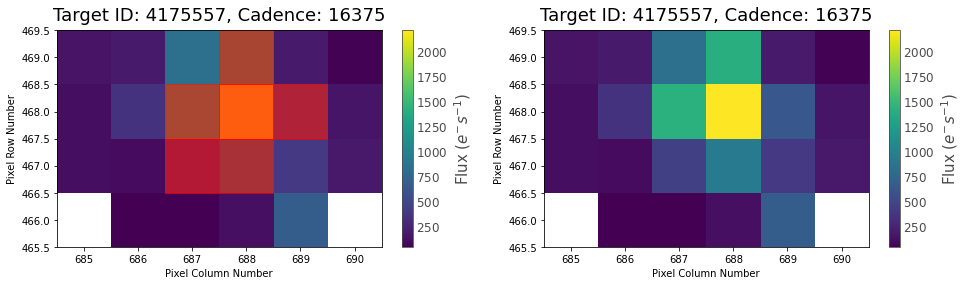

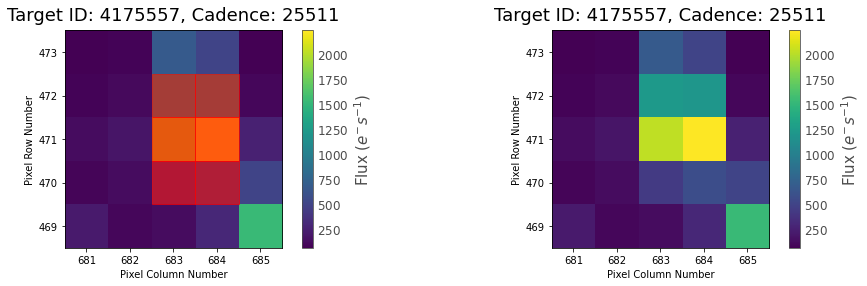

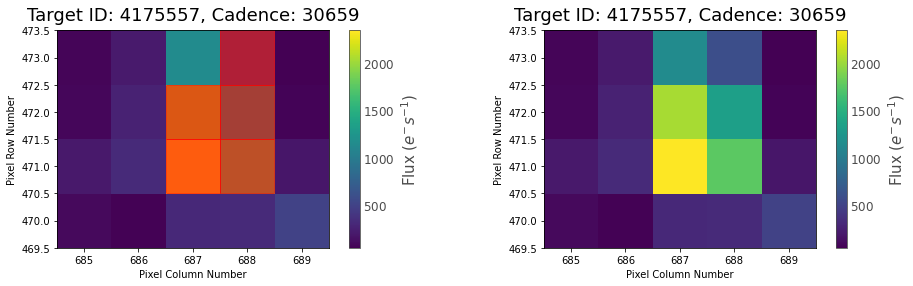

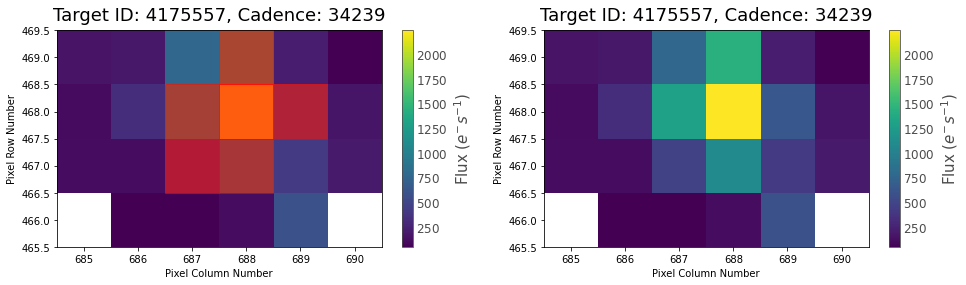

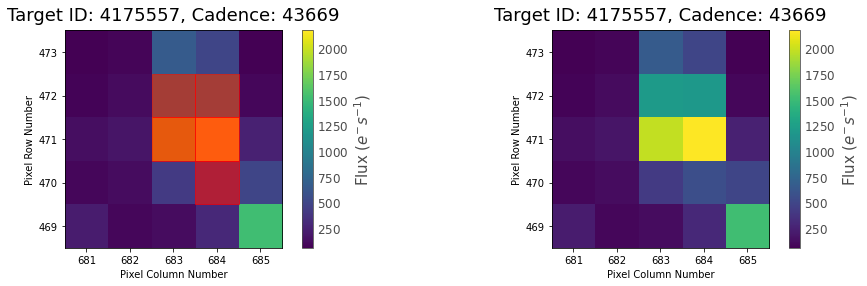

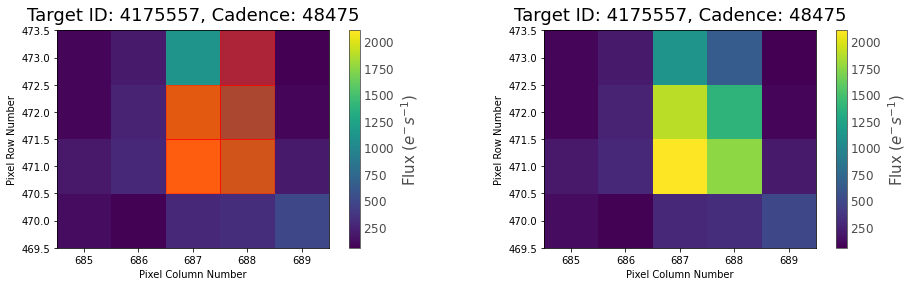

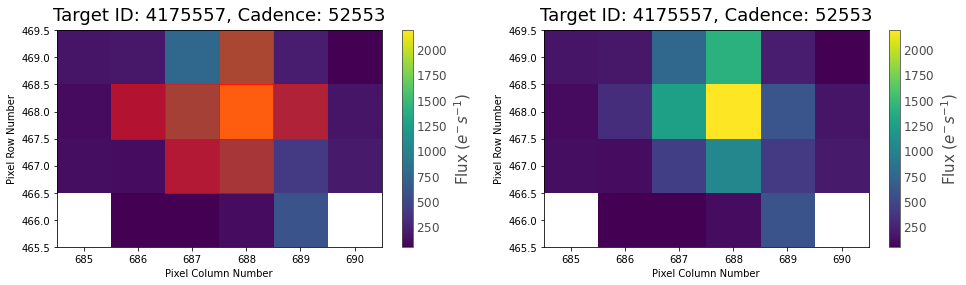

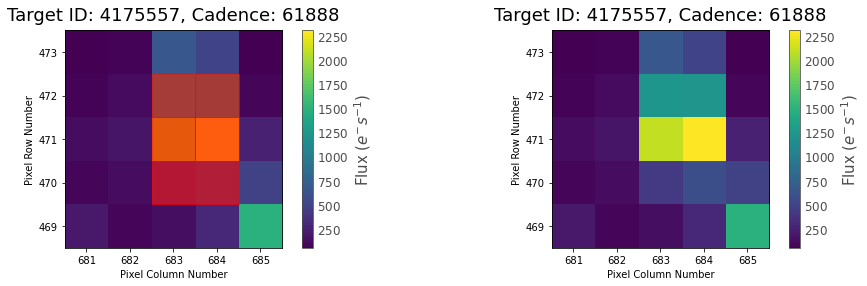

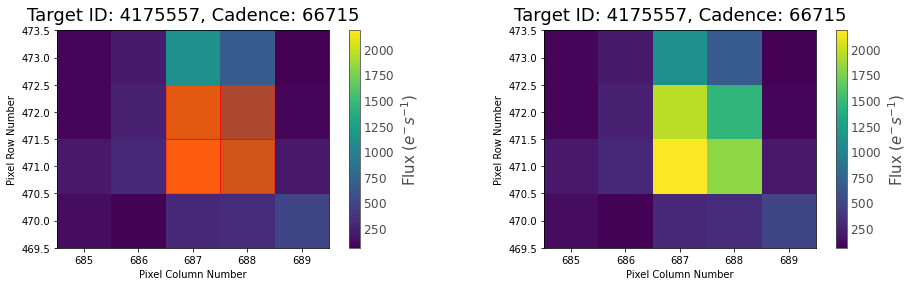

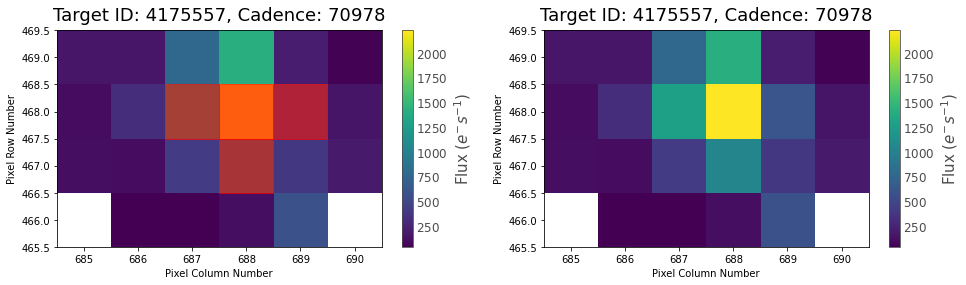

In [3]:
# Check the apertures for quarters where there is data

for quarter in range(len(pixelfile)):
    fig = plt.figure(figsize=plt.figaspect(0.25));
    ax = fig.add_subplot(1, 2, 1)
    pixelfile[quarter].plot(ax=ax, frame=2, aperture_mask=pixelfile[quarter].pipeline_mask, mask_color='red');

    ax = fig.add_subplot(1, 2, 2)
    pixelfile[quarter].plot(ax=ax, frame=2);



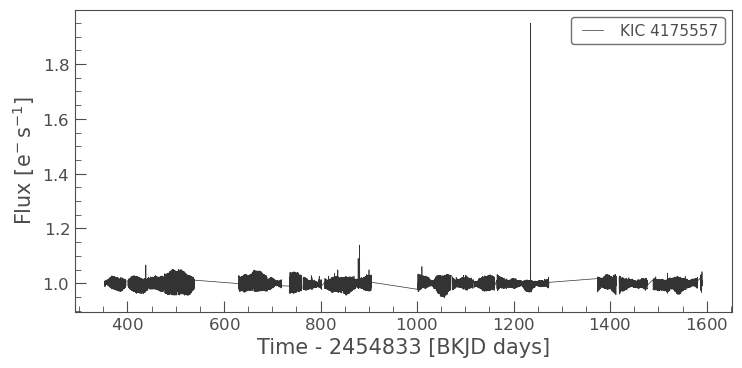

In [4]:
# make light curves out of the pixel data using all quarters, detrended by .flatten() so they line up together
lc = pixelfile[0].to_lightcurve().flatten();
for pf in pixelfile[1:]:
    lc = lc.append(pf.to_lightcurve().flatten())
lc.remove_nans().remove_outliers()

lc.plot();

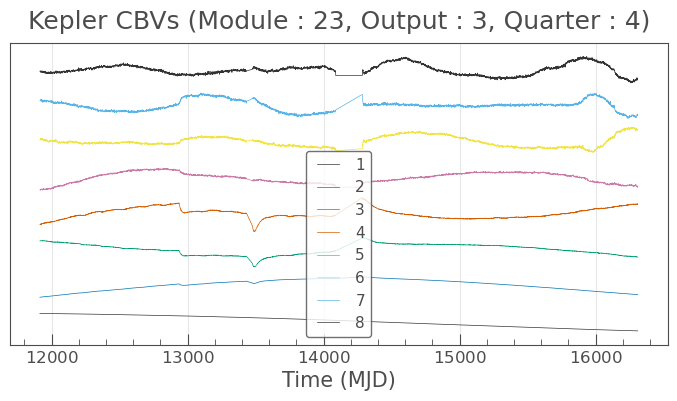

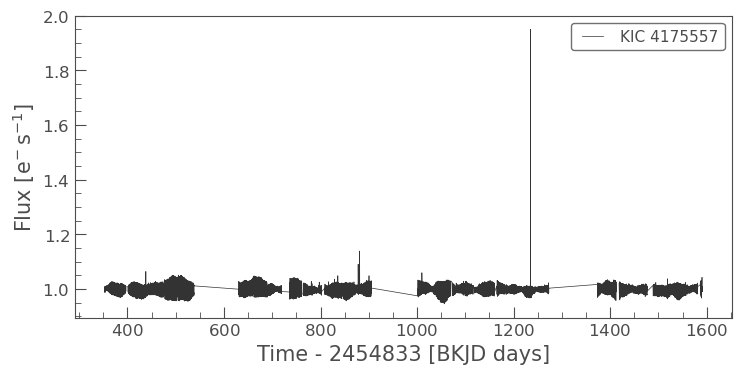

In [5]:
# remove signals that are common to all nearby stars using the Cotrending Basis Vectors (CBVs)

from lightkurve.correctors import KeplerCBVCorrector

# look at example CBVs to make sure they are reasonable
KeplerCBVCorrector(lc).plot_cbvs([1,2,3,4,5,6,7,8]);
# make corrected light curves out of the pixel data using all quarters, detrended by .flatten()
# the .correct() function removes signals correlated with the CBVs
temp_lc = pixelfile[0].to_lightcurve();
corr_lc =  KeplerCBVCorrector(temp_lc).correct(cbvs=[1,2,3]).flatten()
for pf in pixelfile[1:]:
    temp_lc = pf.to_lightcurve()
    corr_lc = corr_lc.append(KeplerCBVCorrector(temp_lc).correct(cbvs=[1,2,3]).flatten())
corr_lc.remove_nans().remove_outliers()
corr_lc.plot();

Text(0.5, 1.0, 'Uncorrected Flux')

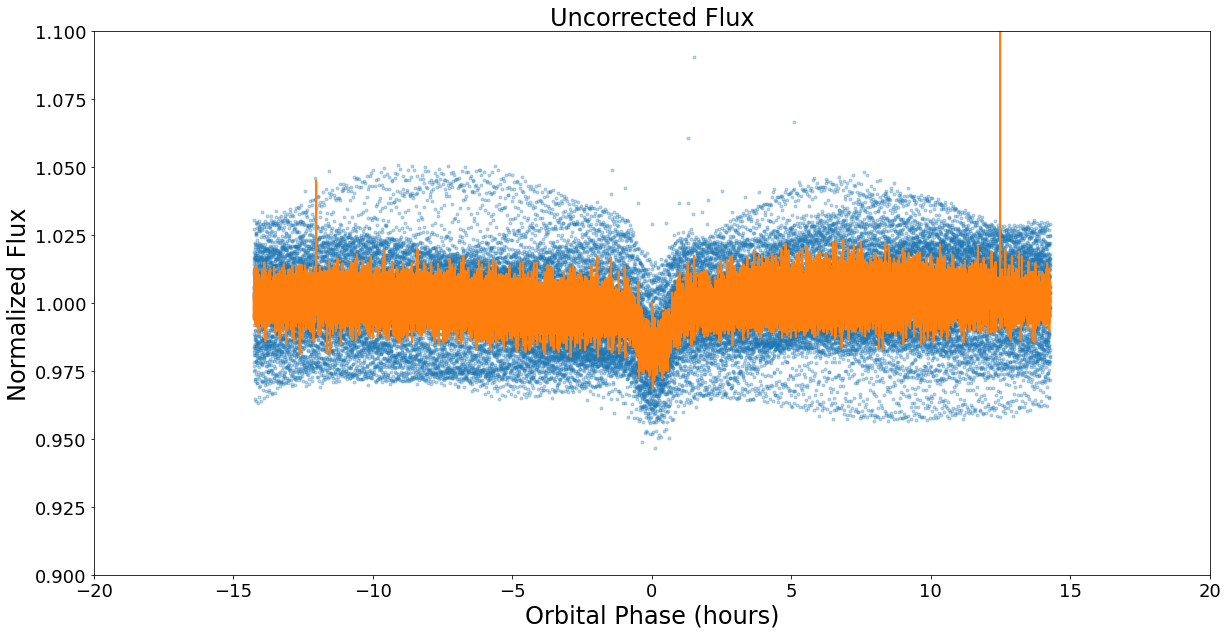

In [6]:
# plot the folded light curve by period and epoch
period = 1.189481;
epoch = 132.104642;

xRangeHours = 20
yRange = 1e-1
binFactor = 5
periodHours = period*24

foldedLc = lc.fold(period = period, t0=epoch)
foldedBinnedLc = lc.fold(period = period, t0=epoch).bin(binFactor)

plt.figure(figsize=(20,10))
plt.plot(foldedLc.phase*periodHours, foldedLc.flux, '.', alpha=0.3)
plt.plot(foldedBinnedLc.phase*periodHours, foldedBinnedLc.flux, lw=2)
plt.xlim(-xRangeHours, xRangeHours)
plt.ylim(1-yRange, 1+yRange);
plt.tick_params(labelsize = 18)
plt.xlabel("Orbital Phase (hours)", fontsize = 24)
plt.ylabel("Normalized Flux", fontsize = 24)
plt.title("Uncorrected Flux", fontsize = 24)


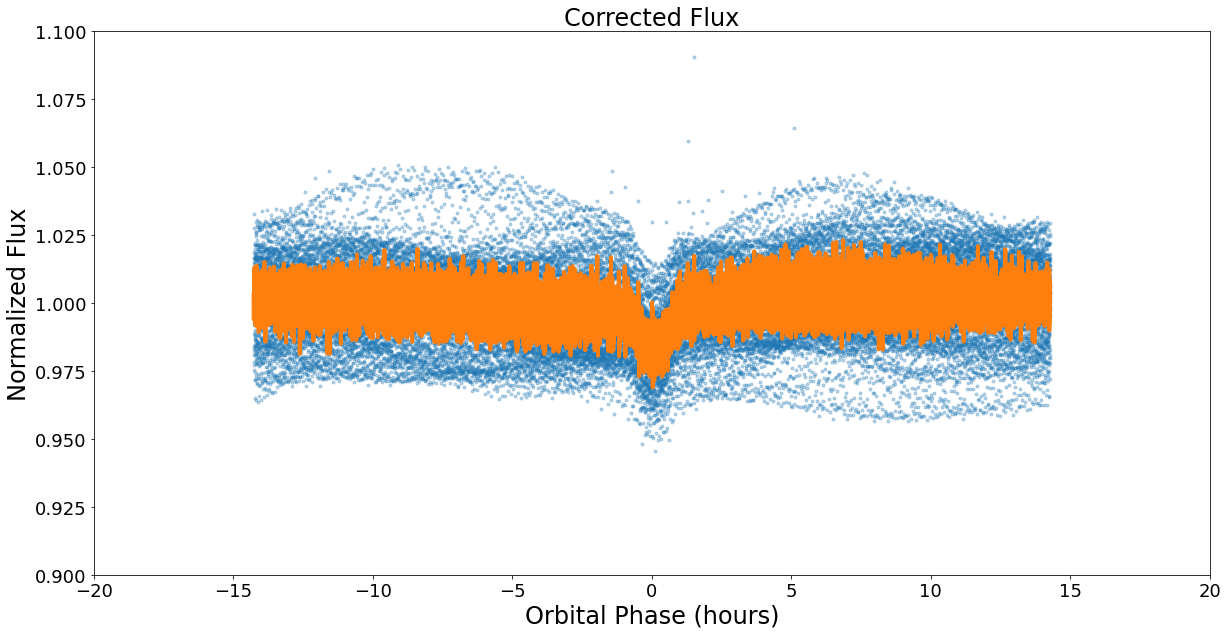

In [7]:
foldedCorrectedLc = corr_lc.fold(period = period, t0=epoch)
foldedBinnedCorrectedLc = corr_lc.fold(period = period, t0=epoch).bin(binFactor).remove_outliers()

plt.figure(figsize=(20,10))
plt.plot(foldedCorrectedLc.phase*periodHours, foldedCorrectedLc.flux, '.', alpha=0.3)
plt.plot(foldedBinnedCorrectedLc.phase*periodHours, foldedBinnedCorrectedLc.flux, lw=4)
plt.xlim(-xRangeHours, xRangeHours)
plt.ylim(1-yRange, 1+yRange);
plt.tick_params(labelsize = 18)
plt.xlabel("Orbital Phase (hours)", fontsize = 24)
plt.ylabel("Normalized Flux", fontsize = 24)
plt.title("Corrected Flux", fontsize = 24)
plt.savefig("TCE7098049-01.pdf",facecolor='white', transparent=False, bbox_inches='tight')


In [8]:
import subprocess
import os
from astropy.io import fits
import numpy as np

def get_dv_model(kepid, tceNum, wgetFileName):
    # grep the file for this kepid
    # a reader is returned
    a =  subprocess.Popen("grep "+str(kepid)+" "+wgetFileName+" | grep _dvt.fits",
                          shell=True, stdout=subprocess.PIPE).stdout
    # decode the output, and split with newline because the same kepid can appear multiple times
    gs = a.read().decode().split("\n")[0]
    # get the fits file URL, which is the fourth term in the output line
    urlStr = gs.split(" ")[3]
    # get the file
    getStr = "wget -O tempFits.fits " + urlStr
    os.system(getStr)
    
    fitsData = fits.open("tempFits.fits")
    # there are several elements:
    # element 0 is overall information
    # followed by one element per TCE
    # so the TCE number correctly indexes into the fits file
    dvModel = {}
    dvModel["model"] = np.zeros(len(fitsData[tceNum].data))
    dvModel["time"] = np.zeros(len(fitsData[tceNum].data))
    for i in range(len(fitsData[tceNum].data)):
        # BKJD time is the first field
        dvModel["time"][i] = fitsData[tceNum].data[i][0]
        # the DV lightcurve model is the 9th field
        dvModel["model"][i] = fitsData[tceNum].data[i][8]

    return dvModel


In [9]:
# requires the file found on the exoplanet archive https://exoplanetarchive.ipac.caltech.edu/bulk_data_download/Kepler_TCE_DV_DR25_wget.bat
transitModel = get_dv_model(7098049, 1, "/Volumes/DR25_data/dvFitsFiles/Kepler_TCE_DV_DR25_wget.bat")


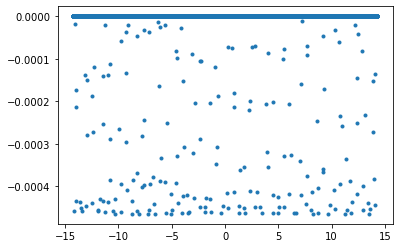

In [10]:
modelPhase = periodHours*np.mod(transitModel["time"] + period/2 - epoch, period)/period - periodHours/2
plt.plot(modelPhase, transitModel["model"], '.')

In [11]:
defaultColors = plt.rcParams['axes.prop_cycle'].by_key()['color']

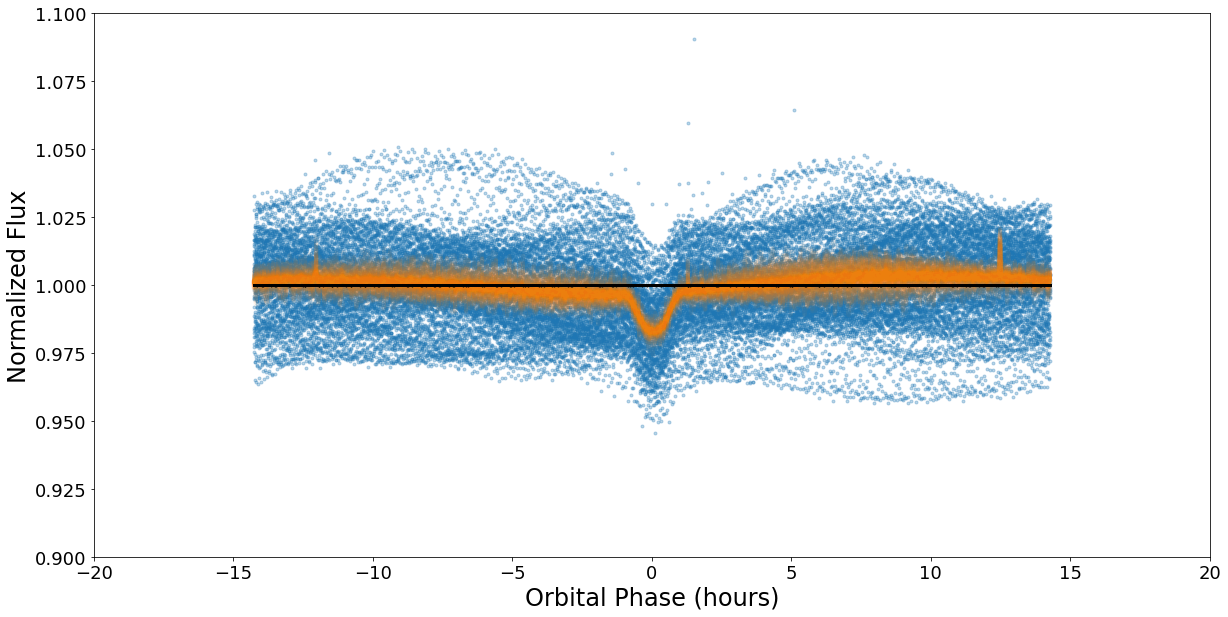

In [12]:
binFactors = range(10,80,1)

plt.figure(figsize=(20,10))
plt.plot(foldedCorrectedLc.phase*periodHours, foldedCorrectedLc.flux, '.', alpha=0.3)
for binFactor in binFactors:
    lc = corr_lc.fold(period = period, t0=epoch).bin(binFactor).remove_outliers()
    plt.plot(lc.phase*periodHours, lc.flux, color=defaultColors[1], lw=4, alpha = 0.05)
plt.plot(modelPhase, transitModel["model"] + 1, 'k.', ms = 2, alpha = 1)
plt.xlim(-xRangeHours, xRangeHours)
plt.ylim(1-yRange, 1+yRange);
plt.tick_params(labelsize = 18)
plt.xlabel("Orbital Phase (hours)", fontsize = 24)
plt.ylabel("Normalized Flux", fontsize = 24)
# plt.title("Corrected Flux", fontsize = 24)
plt.savefig("TCE7098049-01.png",facecolor='white', transparent=False, bbox_inches='tight')
